In [1]:
import os

# Set the Spark version for pydeequ compatibility
os.environ['SPARK_VERSION'] = '3.5'

!pip install kaggle pandas matplotlib seaborn

In [2]:
import json
import zipfile
import logging

import pydeequ
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydeequ.analyzers import *
from pydeequ.profiles import *
from pydeequ.suggestions import *
from pydeequ.checks import *
from pydeequ.verification import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull
from pyspark.sql.types import IntegerType

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
def load_credentials(filepath):
    try:
        with open(filepath, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        logger.error("File not found. Please check the path and try again.")
        raise
    except json.JSONDecodeError:
        logger.error("Error decoding JSON. Please check the file format.")
        raise

def set_kaggle_environment_variables(credentials):
    os.environ['KAGGLE_USERNAME'] = credentials['username']
    os.environ['KAGGLE_KEY'] = credentials['key']

def download_dataset():
    !kaggle datasets download -d abdulszz/spotify-most-streamed-songs

def extract_zip(file_name, extract_to):
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def create_spark_session():
    spark = (SparkSession
        .builder
        .config("spark.jars.packages", pydeequ.deequ_maven_coord)
        .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
        .getOrCreate())
    return spark

In [4]:
credentials = load_credentials('./kaggle.json')
set_kaggle_environment_variables(credentials)
download_dataset()
extract_zip('spotify-most-streamed-songs.zip', 'data')
spark = create_spark_session()

df = spark.read.csv("data/Spotify Most Streamed Songs.csv", header=True, inferSchema=True)
df.show()
df.printSchema()

Dataset URL: https://www.kaggle.com/datasets/abdulszz/spotify-most-streamed-songs
License(s): CC0-1.0
spotify-most-streamed-songs.zip: Skipping, found more recently modified local copy (use --force to force download)
+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+----------+------------------+---------------+-------------------+----------------+----------------+---+----+-----+--------------+---------+--------+--------------+------------------+----------+-------------+--------------------+
|          track_name|      artist(s)_name|artist_count|released_year|released_month|released_day|in_spotify_playlists|in_spotify_charts|   streams|in_apple_playlists|in_apple_charts|in_deezer_playlists|in_deezer_charts|in_shazam_charts|bpm| key| mode|danceability_%|valence_%|energy_%|acousticness_%|instrumentalness_%|liveness_%|speechiness_%|           cover_url|
+--------------------+--------------------+------

In [5]:
# Convert columns to integer type
df = df.withColumn("streams", col("streams").cast("integer"))
df = df.withColumn("in_deezer_playlists", col("in_deezer_playlists").cast("integer"))
df = df.withColumn("in_shazam_charts", col("in_shazam_charts").cast("integer"))

In [12]:
### Data Analyzers section
analysisResult = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("track_name")) \
                    .addAnalyzer(Completeness("artist(s)_name")) \
                    .addAnalyzer(Completeness("released_year")) \
                    .addAnalyzer(Completeness("released_month")) \
                    .addAnalyzer(Completeness("released_day")) \
                    .addAnalyzer(Completeness("in_spotify_playlists")) \
                    .addAnalyzer(Completeness("in_spotify_charts")) \
                    .addAnalyzer(Completeness("streams")) \
                    .addAnalyzer(Completeness("in_apple_playlists")) \
                    .addAnalyzer(Completeness("in_apple_charts")) \
                    .addAnalyzer(Completeness("in_deezer_playlists")) \
                    .addAnalyzer(Completeness("in_deezer_charts")) \
                    .addAnalyzer(Completeness("in_shazam_charts")) \
                    .addAnalyzer(Completeness("bpm")) \
                    .addAnalyzer(Completeness("key")) \
                    .addAnalyzer(Completeness("mode")) \
                    .addAnalyzer(Completeness("danceability_%")) \
                    .addAnalyzer(Completeness("valence_%")) \
                    .addAnalyzer(Completeness("energy_%")) \
                    .addAnalyzer(Completeness("acousticness_%")) \
                    .addAnalyzer(Completeness("instrumentalness_%")) \
                    .addAnalyzer(Completeness("liveness_%")) \
                    .addAnalyzer(Completeness("speechiness_%")) \
                    .addAnalyzer(Completeness("cover_url")) \
                    .addAnalyzer(CountDistinct("mode")) \
                    .addAnalyzer(Compliance("Presto ", "bpm >= 168")) \
                    .addAnalyzer(MaxLength("danceability_%")) \
                    .addAnalyzer(MinLength("released_year")) \
                    .addAnalyzer(Minimum("released_year")) \
                    .addAnalyzer(Maximum("released_year")) \
                    .addAnalyzer(Mean("streams")) \
                    .addAnalyzer(Sum("streams")) \
                    .addAnalyzer(Minimum("bpm")) \
                    .addAnalyzer(Maximum("bpm")) \
                    .addAnalyzer(Mean("danceability_%")) \
                    .addAnalyzer(Mean("valence_%")) \
                    .addAnalyzer(Mean("energy_%")) \
                    .addAnalyzer(Mean("acousticness_%")) \
                    .addAnalyzer(Mean("instrumentalness_%")) \
                    .addAnalyzer(Mean("liveness_%")) \
                    .addAnalyzer(Mean("speechiness_%")) \
                    .run()
                    
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show(100)

+-------+--------------------+-------------+-------------------+
| entity|            instance|         name|              value|
+-------+--------------------+-------------+-------------------+
| Column|      artist(s)_name| Completeness|                1.0|
| Column|             Presto |   Compliance|0.08919202518363065|
| Column|           valence_%|         Mean|  51.43126967471144|
| Column|in_spotify_playlists| Completeness|                1.0|
| Column|             streams|         Mean|4.588303763678533E8|
| Column|             streams|          Sum|   4.25335758893E11|
| Column|             streams| Completeness| 0.9727177334732424|
| Column|           valence_%| Completeness|                1.0|
| Column|                mode| Completeness|                1.0|
| Column|      acousticness_%|         Mean| 27.057712486883524|
| Column|          liveness_%|         Mean| 18.213011542497377|
| Column|       speechiness_%|         Mean| 10.131164742917104|
| Column|  in_apple_playl

In [7]:
### Data profiling section
result = ColumnProfilerRunner(spark) \
    .onData(df) \
    .run()

for col, profile in result.profiles.items():
    print(profile)

NumericProfiles for column: in_spotify_playlists: {
    "completeness": 1.0,
    "approximateNumDistinctValues": 872,
    "dataType": "Integral",
    "isDataTypeInferred": false,
    "typeCounts": {},
    "histogram": null,
    "kll": "None",
    "mean": 5200.124868835257,
    "maximum": 52898.0,
    "minimum": 31.0,
    "sum": 4955719.0,
    "stdDev": 7893.464351417194,
    "approxPercentiles": []
}
NumericProfiles for column: energy_%: {
    "completeness": 1.0,
    "approximateNumDistinctValues": 79,
    "dataType": "Integral",
    "isDataTypeInferred": false,
    "typeCounts": {},
    "histogram": [
        [
            "45",
            13,
            0.013641133263378805
        ],
        [
            "34",
            4,
            0.004197271773347324
        ],
        [
            "67",
            22,
            0.023084994753410283
        ],
        [
            "93",
            3,
            0.0031479538300104933
        ],
        [
            "66",
          

In [8]:
### Constraint Suggestions section
suggestionResult = ConstraintSuggestionRunner(spark) \
             .onData(df) \
             .addConstraintRule(DEFAULT()) \
             .run()

print(json.dumps(suggestionResult, indent=4))

{
    "constraint_suggestions": [
        {
            "constraint_name": "CompletenessConstraint(Completeness(in_spotify_playlists,None,None))",
            "column_name": "in_spotify_playlists",
            "current_value": "Completeness: 1.0",
            "description": "'in_spotify_playlists' is not null",
            "suggesting_rule": "CompleteIfCompleteRule()",
            "rule_description": "If a column is complete in the sample, we suggest a NOT NULL constraint",
            "code_for_constraint": ".isComplete(\"in_spotify_playlists\")"
        },
        {
            "constraint_name": "ComplianceConstraint(Compliance('in_spotify_playlists' has no negative values,in_spotify_playlists >= 0,None,List(in_spotify_playlists),None))",
            "column_name": "in_spotify_playlists",
            "current_value": "Minimum: 31.0",
            "description": "'in_spotify_playlists' has no negative values",
            "suggesting_rule": "NonNegativeNumbersRule()",
            "rul

/usr/local/spark/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


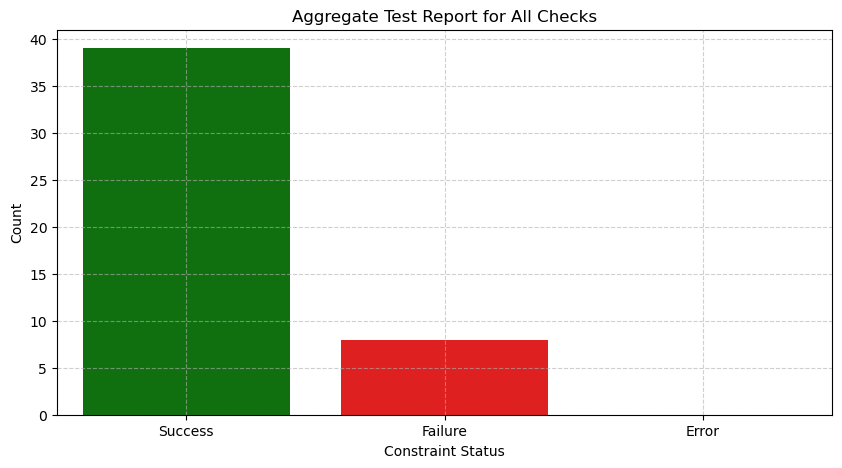

Detailed Results:


,constraint,constraint_status,constraint_message
0,CompletenessConstraint(Completeness(track_name...,Success,
1,CompletenessConstraint(Completeness(artist(s)_...,Success,
2,CompletenessConstraint(Completeness(artist_cou...,Success,
3,CompletenessConstraint(Completeness(released_y...,Success,
4,CompletenessConstraint(Completeness(released_m...,Success,
5,CompletenessConstraint(Completeness(released_d...,Success,
6,CompletenessConstraint(Completeness(in_spotify...,Success,
7,CompletenessConstraint(Completeness(in_spotify...,Success,
8,"CompletenessConstraint(Completeness(streams,No...",Failure,Value: 0.9727177334732424 does not meet the co...
9,CompletenessConstraint(Completeness(in_apple_p...,Success,


In [14]:
### Constraint Verification section
def run_verification(df, check_func, check_name):
    check = Check(spark, CheckLevel.Error, check_name)
    check = check_func(check, df)
    checkResult = VerificationSuite(spark) \
        .onData(df) \
        .addCheck(check) \
        .run()
    return VerificationResult.checkResultsAsDataFrame(spark, checkResult, pandas=True)

def generate_visual_report(results, title):
    combined_results = pd.concat(results)
    status_counts = combined_results['constraint_status'].value_counts()
    status_counts = status_counts.reindex(["Success", "Failure", "Error"], fill_value=0)
    colors = ["green" if status == "Success" else "red" if status == "Failure" else "gray" for status in status_counts.index]
    plot_data = pd.DataFrame({
        'Status': status_counts.index,
        'Counts': status_counts.values,
        'Color': colors
    })
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Status', y='Counts', hue='Color', data=plot_data, dodge=False, palette=colors, legend=False)
    plt.title(title)
    plt.xlabel('Constraint Status')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('test_report.png')
    plt.show()
    
    print("Detailed Results:")
    display_results(combined_results)

def display_results(results_df):
    columns_of_interest = ['constraint', 'constraint_status', 'constraint_message']
    filtered_results = results_df[columns_of_interest]
    display(filtered_results)
    filtered_results.to_html('results.html')  # Save the results to an HTML file

def complete_checks(check, df):
    for column in df.columns:
        check = check.isComplete(column)
    return check

def non_negative_column_checks(check, df):
    integer_columns = [f.name for f in df.schema.fields if isinstance(f.dataType, IntegerType)]
    for column in integer_columns:
        check = check.satisfies(f"`{column}` >= 0", f"{column} is non-negative")
    return check

def mode_check(check, df):
    valid_modes = ["Major", "Minor"]
    check = check.isContainedIn("mode", valid_modes)
    return check

def track_name_uniqueness_check(check, df):
    check = check.isUnique("track_name")
    return check

results = []
results.append(run_verification(df, complete_checks, "Completeness Check for All Columns"))
results.append(run_verification(df, non_negative_column_checks, "Non-Negative Checks"))
results.append(run_verification(df, mode_check, "Mode Check"))
results.append(run_verification(df, track_name_uniqueness_check, "Uniqueness Check for track_name"))

generate_visual_report(results, "Aggregate Test Report for All Checks")

In [15]:
spark.sparkContext._gateway.shutdown_callback_server()
spark.stop()

INFO:py4j.java_gateway:Callback Server Shutting Down
